In [144]:
import numpy as np
import networkx as nx
import random
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np


class NodeLabel:
    def __init__(self, start, end, copy_number):
        self.start = start
        self.end = end
        self.copy_number = copy_number
    
    def get_event(self):
        return (self.start, self.end)
    
    def to_string(self):
        return "(" + str(self.start) + "," + str(self.end) + ") CN:" + str(self.copy_number)
    
    def overlaps(self, node_label):
        return (self.start >= node_label.start and self.start < node_label.end)\
                or (self.end > node_label.start and self.end < node_label.end)
            
class CNSampler:
    #should not contain CN=2
    def __init__(self, CN_to_weight, CN_to_sd):
        self.CN_to_weight = CN_to_weight
        self.CN_to_sd = CN_to_sd
        self.NEUTRAL_CN = 2 
        
    def sample_CN(self):
        return np.random.choice(list(self.CN_to_weight.keys()), 1, p = list(self.CN_to_weight.values()))[0]
    
    def sample_corrected_count(self, count): 
        cc = count + np.random.normal(0, self.CN_to_sd[int(count)], 1)
        while cc < 0:
            cc = count + np.random.normal(0, self.CN_to_sd[int(count)], 1)
        return cc

In [145]:
class TreeGenerator:
    def __init__(self, cn_sampler):
        self.cn_sampler = cn_sampler
        
    def generate_random_tree(self, no_loci, tree_size):
        tree_nodes_list = self.__sample_node_labels(tree_size, no_loci)
        tree = self.__random_tree(tree_nodes_list)
        while not self.__check_valid(tree):
            tree_nodes_list = self.__sample_node_labels(tree_size, no_loci)
            tree = self.__random_tree(tree_nodes_list)
        return tree
    
    def __sample_node_label(self, labels):
        norming_constant = 0
        for z in labels:
            norming_constant += np.exp(0.1 * (z[0] - z[1]))
        while True:
            label = random.sample(labels, 1)[0]
            if np.random.uniform() < np.exp(0.1 * (label[0] - label[1])) / norming_constant:
                return label

    def __sample_node_labels(self, tree_size, no_loci):
        candidates = list(filter(lambda x: x[0] < x[1], [(a, b) for a in range(0, no_loci) for b in range(0, no_loci)]))
        result = list()
        for n in range(0, tree_size):
            label = self.__sample_node_label(candidates)
            candidates.remove(label)
            result.append(NodeLabel(label[0], label[1], self.cn_sampler.sample_CN()))
        result.insert(0, NodeLabel(0, 0, self.cn_sampler.NEUTRAL_CN))
        return result
    
    def __random_tree(self, nodes):
        tree = nx.DiGraph()
        bit_map = np.zeros(len(nodes))
        bit_map[0] = 1
        visited = 1
        current_node = 0
        while len(nodes) > visited:
            new_node = random.sample(range(0, len(nodes)), 1)[0]
            if bit_map[new_node] == 0.0:
                bit_map[new_node] = 1.0
                tree.add_edge(nodes[current_node], nodes[new_node])
                visited += 1
            current_node = new_node
        return tree
    
    def __check_valid(self, tree):
        for node in tree:
            if node.copy_number == 0:
                children = [x[1] for x in list(nx.edge_dfs(tree,list(tree.nodes)[0]))]
                for c in children:
                    if c.copy_number > 0 and node.overlaps(c):
                        return False
        return True

In [151]:
class CountsGenerator:
    def __init__(self, cn_sampler):
        self.cn_sampler = cn_sampler
        
    def generate_data(self, no_loci, tree, no_of_cells):
        counts = np.zeros([0, no_loci], dtype=np.float64)
        
        node_to_counts = self.__fill_node_to_counts(tree, no_loci)
        
        attachment_probs = np.random.dirichlet(np.ones(len(tree.nodes) - 1)).transpose()
        attachment = []
        
        for cell in range(0, no_of_cells):
            attachment_node = random.choices(list(tree.nodes)[1:], k=1, weights=list(attachment_probs))[0]
            counts = np.vstack([counts, node_to_counts[attachment_node]])
            attachment.append(attachment_node.get_event())
        
        corrected_counts = self.__add_noise_to_counts(counts)
        diff_matrix = self.__create_diff_matrix(corrected_counts)
        return counts, attachment, corrected_counts, diff_matrix
    
    def __fill_node_to_counts(self, tree, no_loci):
        counts = np.zeros([1, no_loci], dtype=np.float64)
        counts.fill(self.cn_sampler.NEUTRAL_CN)
        node_to_counts = {}
        
        for node in tree:
            path = nx.shortest_path(tree, list(tree.nodes)[0], node)
            node_counts = np.copy(counts)
            for i in range(0, len(path)):
                ancestor = path[i]
                for j in range(ancestor.start, ancestor.end):
                    node_counts[0, j] = ancestor.copy_number
            node_to_counts[node] = node_counts    
        return node_to_counts
    
    def __add_noise_to_counts(self, counts):
        cc = np.copy(counts)
        for i in range(0, counts.shape[0]):
            for j in range(0, counts.shape[1]):
                cc[i,j] = self.cn_sampler.sample_corrected_count(counts[i,j])
        return cc
    
    def __create_diff_matrix(self, corrected_counts):
        diffs = np.copy(corrected_counts)
        
        for cell in range(0, diffs.shape[0]):
            for loci in range(0, diffs.shape[1]):
                if loci == 0:
                    diffs[cell, loci] = np.abs(corrected_counts[cell, loci] - self.cn_sampler.NEUTRAL_CN)
                else:
                    diffs[cell, loci] = np.abs(corrected_counts[cell, loci] - corrected_counts[cell, loci - 1])
        return diffs

In [152]:
cn_s = CNSampler({0 : 0.1, 1 : 0.5, 3 : 0.4}, {0 : 0.1, 1 : 0.5, 3 : 0.4, 2 : 0.5})

In [153]:
d = TreeGenerator(cn_s)

In [164]:
tree = d.generate_random_tree(40, 10)
dd = CountsGenerator(cn_s)
data = dd.generate_data(40, tree, 200)

ccs = data[2]
ccs = ccs.flatten()
diffs = data[3]
diffs = diffs.flatten()

In [165]:
#Plot the ground truth tree
plt.figure(3, figsize=(12,12))
pos = graphviz_layout(tree, prog = "dot")
nx.draw(tree, pos = pos, with_labels=True, node_color = "grey", node_size = 60, verticalalignment = "bottom",
       font_size=20, edge_color="grey", font_color="green")
plt.show()

FileNotFoundError: [WinError 2] "dot" not found in path.

<Figure size 864x864 with 0 Axes>

(array([0.02677473, 0.02395633, 0.04509428, 0.06200463, 0.09018855,
        0.09300695, 0.08455177, 0.15923916, 0.15923916, 0.17333113,
        0.19165068, 0.21701621, 0.20574264, 0.28324843, 0.2550645 ,
        0.29734039, 0.29029441, 0.38471055, 0.4030301 , 0.37202778,
        0.38893814, 0.43403241, 0.44953357, 0.42134965, 0.44389679,
        0.38752894, 0.41289447, 0.37061859, 0.36357261, 0.35793582,
        0.41853125, 0.39175653, 0.39316572, 0.35229904, 0.3649818 ,
        0.32693351, 0.26774727, 0.23815415, 0.22828978, 0.15923916,
        0.10428051, 0.0746874 , 0.04932187, 0.02818392, 0.01268277,
        0.00422759, 0.00563678, 0.0014092 , 0.00281839, 0.0014092 ]),
 array([0.00650108, 0.09520413, 0.18390718, 0.27261023, 0.36131329,
        0.45001634, 0.53871939, 0.62742245, 0.7161255 , 0.80482855,
        0.8935316 , 0.98223466, 1.07093771, 1.15964076, 1.24834381,
        1.33704687, 1.42574992, 1.51445297, 1.60315603, 1.69185908,
        1.78056213, 1.86926518, 1.95796824, 2.

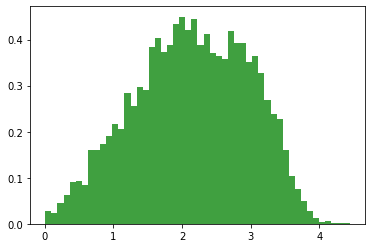

In [166]:
 plt.hist(ccs, 50, density=True, facecolor='g', alpha=0.75)

(array([1.14964977, 1.208851  , 1.09426797, 1.03506674, 1.06753193,
        0.94531003, 0.87083105, 0.85555332, 0.80399095, 0.76006745,
        0.71423424, 0.6206581 , 0.47170015, 0.53663054, 0.35902684,
        0.38576288, 0.32274221, 0.29409645, 0.25972154, 0.20624946,
        0.1776037 , 0.14131907, 0.11458303, 0.12031219, 0.09548586,
        0.07065954, 0.07256925, 0.05920123, 0.06302067, 0.05347208,
        0.05347208, 0.04583321, 0.04201378, 0.02482632, 0.03819434,
        0.02864576, 0.01909717, 0.02673604, 0.01527774, 0.01527774,
        0.00572915, 0.00381943, 0.00954859, 0.00190972, 0.00381943,
        0.00381943, 0.00190972, 0.00381943, 0.00190972, 0.00190972]),
 array([5.02528651e-05, 6.55049697e-02, 1.30959686e-01, 1.96414403e-01,
        2.61869120e-01, 3.27323837e-01, 3.92778554e-01, 4.58233270e-01,
        5.23687987e-01, 5.89142704e-01, 6.54597421e-01, 7.20052138e-01,
        7.85506854e-01, 8.50961571e-01, 9.16416288e-01, 9.81871005e-01,
        1.04732572e+00, 1.1127

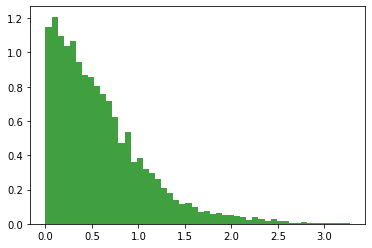

In [167]:
 plt.hist(diffs, 50, density=True, facecolor='g', alpha=0.75)